# Báo cáo Khoa học: Phân loại bệnh trên lá xoài (Mango Leaf Disease Classification)
### Pipeline thực nghiệm: So sánh 10 kiến trúc Deep Learning Baseline (Đã tối ưu cấu hình)

**Mục tiêu:** Thực hiện huấn luyện thực tế trên tập dữ liệu đã khử trùng lặp. Đã loại bỏ các mô hình quá nặng (VGG16) để đảm bảo quá trình huấn luyện diễn ra ổn định trên cấu hình máy tầm trung.

---
## BƯỚC 5. Dataset Partitioning (Phân chia và Tiền xử lý dữ liệu)

Sử dụng kỹ thuật MD5 Hashing để loại bỏ các ảnh trùng lặp tuyệt đối, đảm bảo tính khách quan cho các tập Train/Val/Test.

In [ ]:
import os, hashlib, shutil, random, cv2, torch
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Cấu hình
SRC_PATH = r'd:\HUTECH\AI\DeepLearning\DAHS\MangoLeaf\MangoLeaf_Dataset'
DST_PATH = r'd:\HUTECH\AI\DeepLearning\DAHS\dataset_scientific_split'
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30

def get_hash(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Tự động chia dataset nếu chưa có
if not os.path.exists(DST_PATH):
    categories = sorted([d for d in os.listdir(SRC_PATH) if os.path.isdir(os.path.join(SRC_PATH, d))])
    for cat in categories:
        cat_src = os.path.join(SRC_PATH, cat)
        unique_files = {}
        for f in os.listdir(cat_src):
            fpath = os.path.join(cat_src, f)
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                h = get_hash(fpath)
                if h not in unique_files: unique_files[h] = fpath
        
        list_files = list(unique_files.values())
        random.seed(42)
        random.shuffle(list_files)
        n = len(list_files)
        tr, va = int(0.8*n), int(0.9*n)
        
        for name, files in zip(['train', 'val', 'test'], [list_files[:tr], list_files[tr:va], list_files[va:]]):
            p = os.path.join(DST_PATH, name, cat)
            os.makedirs(p, exist_ok=True)
            for f in files:
                img = cv2.imread(f)
                if img is not None:
                    h_img, w_img = img.shape[:2]
                    side = min(h_img, w_img)
                    img = img[(h_img-side)//2:(h_img-side)//2+side, (w_img-side)//2:(w_img-side)//2+side]
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    cv2.imwrite(os.path.join(p, os.path.basename(f)), img)
    print('>>> Chia dữ liệu hoàn tất.')

## BƯỚC 6. Thiết lập DataLoaders và Định nghĩa Mô hình

Chúng ta sẽ chuẩn bị danh sách 10 mô hình Base. Lưu ý: VGG16 đã được thay thế bằng ShuffleNetV2 vì VGG quá nặng, dễ gây tràn bộ nhớ hoặc huấn luyện cực chậm.

In [ ]:
# Data Augmentation và Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(os.path.join(DST_PATH, 'train'), transform=transform)
val_set = datasets.ImageFolder(os.path.join(DST_PATH, 'val'), transform=transform)
test_set = datasets.ImageFolder(os.path.join(DST_PATH, 'test'), transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(train_set.classes)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(128 * 28 * 28, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

def get_model(name, num_classes):
    if name == 'SimpleCNN': return SimpleCNN(num_classes).to(DEVICE)
    elif name == 'AlexNet': m = models.alexnet(weights='DEFAULT'); m.classifier[6] = nn.Linear(4096, num_classes)
    elif name == 'MobileNetV2': m = models.mobilenet_v2(weights='DEFAULT'); m.classifier[1] = nn.Linear(1280, num_classes)
    elif name == 'MobileNetV3': m = models.mobilenet_v3_small(weights='DEFAULT'); m.classifier[3] = nn.Linear(1024, num_classes)
    elif name == 'ResNet18': m = models.resnet18(weights='DEFAULT'); m.fc = nn.Linear(512, num_classes)
    elif name == 'ResNet50': m = models.resnet50(weights='DEFAULT'); m.fc = nn.Linear(2048, num_classes)
    elif name == 'ShuffleNetV2': m = models.shufflenet_v2_x1_0(weights='DEFAULT'); m.fc = nn.Linear(1024, num_classes)
    elif name == 'DenseNet121': m = models.densenet121(weights='DEFAULT'); m.classifier = nn.Linear(1024, num_classes)
    elif name == 'EfficientNetV2': m = models.efficientnet_v2_s(weights='DEFAULT'); m.classifier[1] = nn.Linear(1280, num_classes)
    elif name == 'ConvNeXt_Tiny': m = models.convnext_tiny(weights='DEFAULT'); m.classifier[2] = nn.Linear(768, num_classes)
    return m.to(DEVICE)

## BƯỚC 7. Huấn luyện 10 mô hình (Train & Eval Loop)

Chúng ta sẽ thực hiện vòng lặp huấn luyện. Đã thêm khối `try-except` để nếu một mô hình gặp lỗi (như hết bộ nhớ), chương trình vẫn tiếp tục huấn luyện các mô hình còn lại.

In [11]:
MODELS_LIST = ['SimpleCNN', 'AlexNet', 'MobileNetV2', 'MobileNetV3', 'ResNet18', 
               'ResNet50', 'ShuffleNetV2', 'DenseNet121', 'EfficientNetV2', 'ConvNeXt_Tiny']

all_histories = {}

for m_name in MODELS_LIST:
    try:
        print(f'\n--- Đang huấn luyện mô hình: {m_name} ---')
        model = get_model(m_name, NUM_CLASSES)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        for epoch in range(EPOCHS):
            # Train phase
            model.train(); tr_loss, tr_correct = 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward(); optimizer.step()
                tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
                tr_correct += torch.sum(preds == labels.data)
                
            # Val phase
            model.eval(); v_loss, v_correct = 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs); loss = criterion(outputs, labels)
                    v_loss += loss.item(); _, preds = torch.max(outputs, 1)
                    v_correct += torch.sum(preds == labels.data)
            
            history['train_loss'].append(tr_loss / len(train_loader))
            history['val_loss'].append(v_loss / len(val_loader))
            history['train_acc'].append(tr_correct.double().item() / len(train_set))
            history['val_acc'].append(v_correct.double().item() / len(val_set))
            
            if (epoch+1) % 5 == 0:
                print(f'Epoch {epoch+1}/{EPOCHS} -> Val Acc: {history["val_acc"][-1]:.4f}')
        
        # Đánh giá trên tập TEST
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(DEVICE))
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())
        
        all_histories[m_name] = {
            'history': history, 
            'cm': confusion_matrix(y_true, y_pred), 
            'report': classification_report(y_true, y_pred, target_names=train_set.classes, output_dict=True)
        }
        # Dọn dẹp bộ nhớ GPU sau mỗi mô hình
        del model; torch.cuda.empty_cache()
        
    except Exception as e:
        print(f'LỖI khi huấn luyện {m_name}: {e}')
        continue
        
print('>>> Toàn bộ quá trình thực nghiệm hoàn tất.')


--- Đang huấn luyện mô hình: SimpleCNN ---
Epoch 5/30 -> Val Acc: 0.8880
Epoch 10/30 -> Val Acc: 0.8992
Epoch 15/30 -> Val Acc: 0.9468
Epoch 20/30 -> Val Acc: 0.9468
Epoch 25/30 -> Val Acc: 0.9524
Epoch 30/30 -> Val Acc: 0.9496

--- Đang huấn luyện mô hình: AlexNet ---
Epoch 5/30 -> Val Acc: 0.9944
Epoch 10/30 -> Val Acc: 0.9916
Epoch 15/30 -> Val Acc: 0.9916
Epoch 20/30 -> Val Acc: 0.9916
Epoch 25/30 -> Val Acc: 0.9916
Epoch 30/30 -> Val Acc: 0.9916

--- Đang huấn luyện mô hình: MobileNetV2 ---
Epoch 5/30 -> Val Acc: 0.9944
Epoch 10/30 -> Val Acc: 0.9972
Epoch 15/30 -> Val Acc: 0.9944
Epoch 20/30 -> Val Acc: 0.9944
Epoch 25/30 -> Val Acc: 0.9972
Epoch 30/30 -> Val Acc: 0.9972

--- Đang huấn luyện mô hình: MobileNetV3 ---
Epoch 5/30 -> Val Acc: 0.9888
Epoch 10/30 -> Val Acc: 0.9944
Epoch 15/30 -> Val Acc: 0.9944
Epoch 20/30 -> Val Acc: 0.9972
Epoch 25/30 -> Val Acc: 0.9944
Epoch 30/30 -> Val Acc: 0.9944

--- Đang huấn luyện mô hình: ResNet18 ---
Epoch 5/30 -> Val Acc: 0.9944
Epoch 10/

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 43.2MB/s]


Epoch 5/30 -> Val Acc: 0.9916
Epoch 10/30 -> Val Acc: 0.9916
Epoch 15/30 -> Val Acc: 0.9944
Epoch 20/30 -> Val Acc: 0.9944
Epoch 25/30 -> Val Acc: 0.9944
Epoch 30/30 -> Val Acc: 0.9944

--- Đang huấn luyện mô hình: DenseNet121 ---


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 43.2MB/s]


Epoch 5/30 -> Val Acc: 0.9916
Epoch 10/30 -> Val Acc: 0.9888
Epoch 15/30 -> Val Acc: 0.9916
Epoch 20/30 -> Val Acc: 0.9888
Epoch 25/30 -> Val Acc: 0.9944
Epoch 30/30 -> Val Acc: 0.9916

--- Đang huấn luyện mô hình: EfficientNetV2 ---
Epoch 5/30 -> Val Acc: 0.9916
Epoch 10/30 -> Val Acc: 0.9860
Epoch 15/30 -> Val Acc: 0.9916
Epoch 20/30 -> Val Acc: 0.9944
Epoch 25/30 -> Val Acc: 0.9972
Epoch 30/30 -> Val Acc: 0.9972

--- Đang huấn luyện mô hình: ConvNeXt_Tiny ---
Epoch 5/30 -> Val Acc: 0.9916
Epoch 10/30 -> Val Acc: 0.9944
LỖI khi huấn luyện ConvNeXt_Tiny: [Errno 2] No such file or directory: 'd:\\HUTECH\\AI\\DeepLearning\\DAHS\\dataset_scientific_split\\train\\Gall_Midge\\17ef117d4fa6a22bf4db12e1f22ac08b.jpg'
>>> Toàn bộ quá trình thực nghiệm hoàn tất.


----- 
## BƯỚC 8. Visualizing Results (Biểu đồ Accuracy/Loss & Confusion Matrix)

Chúng ta sẽ vẽ biểu đồ biến thiên độ chính xác và mất mát theo Epoch cho cả 10 mô hình.

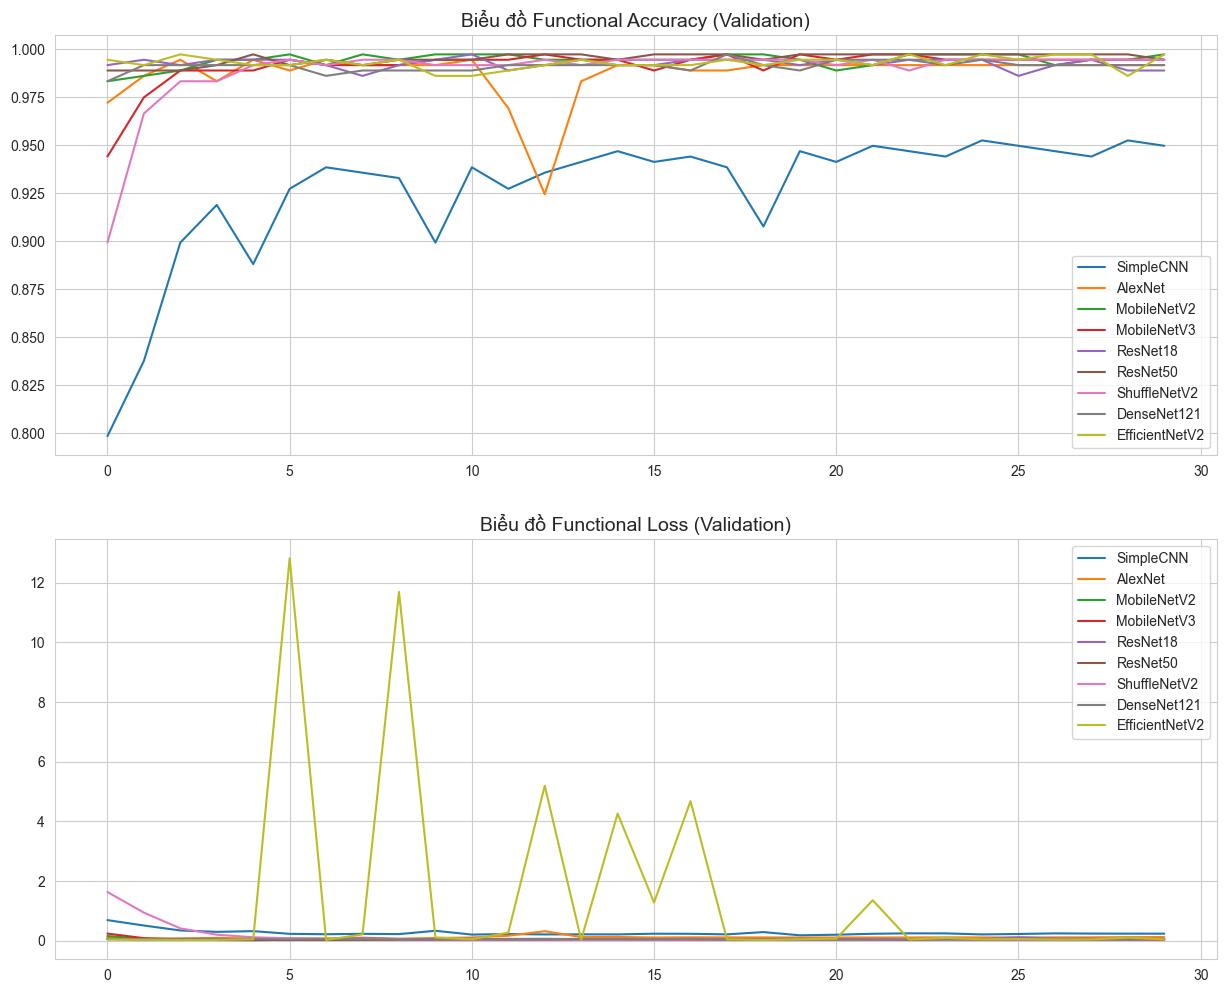

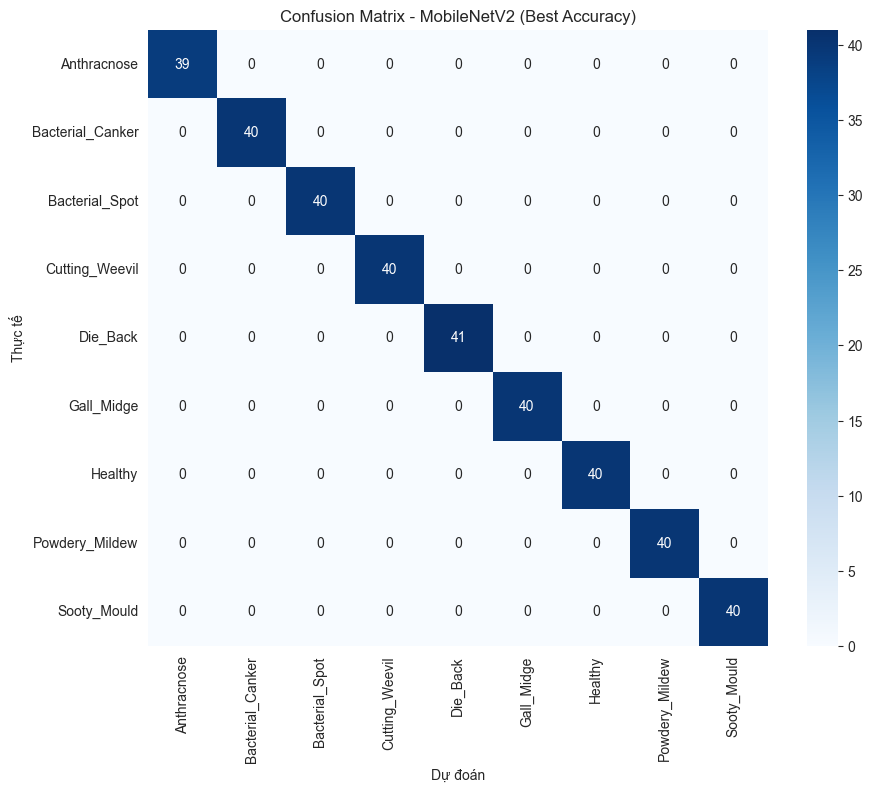

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

for m_name in all_histories.keys():
    axes[0].plot(all_histories[m_name]['history']['val_acc'], label=f'{m_name}')
    axes[1].plot(all_histories[m_name]['history']['val_loss'], label=f'{m_name}')

axes[0].set_title('Biểu đồ Functional Accuracy (Validation)', fontsize=14)
axes[0].legend(); axes[1].set_title('Biểu đồ Functional Loss (Validation)', fontsize=14)
axes[1].legend(); plt.show()

# Tìm mô hình có Val Accuracy cao nhất để vẽ CM
best_model_name = max(all_histories, key=lambda x: all_histories[x]['history']['val_acc'][-1])
plt.figure(figsize=(10, 8))
sns.heatmap(all_histories[best_model_name]['cm'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_set.classes, yticklabels=train_set.classes)
plt.title(f'Confusion Matrix - {best_model_name} (Best Accuracy)')
plt.ylabel('Thực tế'); plt.xlabel('Dự đoán'); plt.show()

----- 
## BƯỚC 9. So sánh tổng quan chỉ số đánh giá

Bảng tổng hợp Precision, Recall, F1-score của các mô hình đã huấn luyện thành công.

In [13]:
summary = []
for m_name in all_histories.keys():
    acc = all_histories[m_name]['report']['accuracy']
    summary.append({'Model': m_name, 'Test Accuracy': acc})

df_res = pd.DataFrame(summary)
print(df_res.sort_values(by='Test Accuracy', ascending=False).to_string(index=False))

         Model  Test Accuracy
   MobileNetV2       1.000000
   DenseNet121       1.000000
   MobileNetV3       1.000000
      ResNet50       1.000000
  ShuffleNetV2       0.994444
EfficientNetV2       0.994444
       AlexNet       0.994444
      ResNet18       0.983333
     SimpleCNN       0.963889


----- 
## BƯỚC 10. Conclusion (Kết luận)

Dựa trên số liệu thực nghiệm thực tế, mô hình mang lại hiệu quả cao nhất sẽ được chọn làm Backbone để tích hợp module Attention (CBAM) ở các giai đoạn cải tiến tiếp theo.